# Shopping Mall Site Selection

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")
%matplotlib inline

Libraries imported.


In [2]:
df=pd.read_csv("Pune_Localities.csv")

In [3]:
df.head()

Localities_name                                     Localities_url
0      Alandi Road  https://www.mapsofindia.com/pune/localities/al...
1  Ambegaon Budruk  https://www.mapsofindia.com/pune/localities/am...
2       Anandnagar  https://www.mapsofindia.com/pune/localities/an...
3            Aundh  https://www.mapsofindia.com/pune/localities/au...
4       Aundh Road  https://www.mapsofindia.com/pune/localities/au...

In [4]:
df.shape

(96, 2)

# Get geographical coordinates

In [5]:
# define a function to get coordinates
def get_latlng(Localities_name):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Pune, Maharashtra'.format(Localities_name))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [6]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(Localities_name) for Localities_name in df["Localities_name"].tolist() ]

In [7]:
coords

[[18.55248655755337, 73.87319311253812],
 [18.453520000000026, 73.83887000000004],
 [18.597540000000038, 73.90929000000006],
 [18.563450000000046, 73.81227000000007],
 [18.555231455999067, 73.81865590591383],
 [18.545740000000023, 73.92614000000003],
 [18.548200000000065, 73.77316000000008],
 [18.548385753902522, 73.81377638977878],
 [18.51812966328083, 73.83587093829442],
 [18.512975860118864, 73.86528927407815],
 [18.471870000000024, 73.86336000000006],
 [18.57176000000004, 73.83340000000004],
 [18.516890000000046, 73.85617000000008],
 [18.53104417318853, 73.8790769814441],
 [18.524590000000046, 73.87878000000006],
 [18.561690000000056, 73.93122000000005],
 [18.494410000000073, 74.39857000000006],
 [18.515850000000057, 73.84061000000008],
 [18.679160000000024, 73.73255000000006],
 [18.46628000000004, 73.85326000000003],
 [18.447020000000066, 73.80757000000006],
 [18.534852767033737, 73.87623781534374],
 [18.509650000000022, 73.83124000000004],
 [18.505840000000035, 73.90232000000003]

In [8]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [9]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [10]:
# check the neighborhoods and the coordinates
print(df.shape)
df.head()

(96, 4)


Localities_name                                     Localities_url  \
0      Alandi Road  https://www.mapsofindia.com/pune/localities/al...   
1  Ambegaon Budruk  https://www.mapsofindia.com/pune/localities/am...   
2       Anandnagar  https://www.mapsofindia.com/pune/localities/an...   
3            Aundh  https://www.mapsofindia.com/pune/localities/au...   
4       Aundh Road  https://www.mapsofindia.com/pune/localities/au...   

    Latitude  Longitude  
0  18.552487  73.873193  
1  18.453520  73.838870  
2  18.597540  73.909290  
3  18.563450  73.812270  
4  18.555231  73.818656

#  Create a map of Pune with neighborhoods superimposed on top

In [11]:
# get the coordinates of Pune
address = 'Pune, Maharashtra'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Pune, Maharashtra {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Pune, Maharashtra 18.521428, 73.8544541.


In [12]:
# create map of Pune using latitude and longitude values
map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, localities in zip(df['Latitude'], df['Longitude'], df['Localities_name']):
    label = '{}'.format(localities)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map)  
    
map

# Use the Foursquare API to explore the neighborhoods¶

In [13]:
# define Foursquare Credentials and Version
CLIENT_ID = '31WVQMK5HJ3XOOWUQEHMHJ51GPOSV3VEHWSDAFAL1VL5ZGBK' # your Foursquare ID
CLIENT_SECRET = 'YGB3PKZJSVQQFFLLFSJ5XT4R0VGPA1S3AP4VK1IEBFG5ZSB1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 31WVQMK5HJ3XOOWUQEHMHJ51GPOSV3VEHWSDAFAL1VL5ZGBK
CLIENT_SECRET:YGB3PKZJSVQQFFLLFSJ5XT4R0VGPA1S3AP4VK1IEBFG5ZSB1


In [14]:
radius = 5000 
LIMIT = 500

venues = []

for lat, long, localities in zip(df['Latitude'], df['Longitude'], df['Localities_name']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius,
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]["groups"][0]["items"]
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            localities,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [15]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Localities_name', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(8420, 7)


Localities_name   Latitude  Longitude                      VenueName  \
0     Alandi Road  18.552487  73.873193  Hidden Place - The Crazy Frog   
1     Alandi Road  18.552487  73.873193                La Bouchee d'Or   
2     Alandi Road  18.552487  73.873193                    La Pizzeria   
3     Alandi Road  18.552487  73.873193                    Conrad Pune   
4     Alandi Road  18.552487  73.873193                Poona Golf Club   

   VenueLatitude  VenueLongitude       VenueCategory  
0      18.536546       73.875394                 Pub  
1      18.538931       73.876677              Bakery  
2      18.539621       73.883401  Italian Restaurant  
3      18.535020       73.883056               Hotel  
4      18.553242       73.888993         Golf Course

In [16]:
venues_df.groupby(["Localities_name"]).count()

Latitude  Longitude  VenueName  VenueLatitude  \
Localities_name                                                             
Alandi Road                      100        100        100            100   
Ambegaon Budruk                   70         70         70             70   
Anandnagar                       100        100        100            100   
Aundh                            100        100        100            100   
Aundh Road                       100        100        100            100   
Balaji Nagar                     100        100        100            100   
Baner                            100        100        100            100   
Baner road                       100        100        100            100   
Bhandarkar Road                  100        100        100            100   
Bhavani Peth                     100        100        100            100   
Bibvewadi                        100        100        100            100   
Bopodi                            96         96         96             96   
Budhwar Peth                     100        100        100            100   
Bund Garden Road                 100        100        100            100   
Camp                             100        100        100            100   
Chandan Nagar                    100        100        100            100   
Dapodi                             3          3          3              3   
Deccan Gymkhana                  100        100        100            100   
Dehu Road                         41         41         41             41   
Dhankawadi                        94         94         94             94   
Dhayari Phata                     28         28         28             28   
Dhole Patil Road                 100        100        100            100   
Erandwane                        100        100        100            100   
Fatima Nagar                     100        100        100            100   
Fergusson College Road           100        100        100            100   
Ganesh Peth                      100        100        100            100   
Ganeshkhind                      100        100        100            100   
Ghorpade Peth                    100        100        100            100   
Ghorpadi                          78         78         78             78   
Gokhale Nagar                    100        100        100            100   
Gultekdi                         100        100        100            100   
Guruwar peth                     100        100        100            100   
Hadapsar                         100        100        100            100   
Hadapsar Industrial Estate       100        100        100            100   
Hingne Khurd                      98         98         98             98   
Jangali Maharaj Road             100        100        100            100   
Kalyani Nagar                    100        100        100            100   
Karve Nagar                      100        100        100            100   
Karve Road                       100        100        100            100   
Kasba Peth                       100        100        100            100   
Katraj                            67         67         67             67   
Khadaki                            6          6          6              6   
Khadki                           100        100        100            100   
Kharadi                          100        100        100            100   
Kondhwa                           18         18         18             18   
Kondhwa Budruk                    85         85         85             85   
Kondhwa Khurd                    100        100        100            100   
Koregaon Park                    100        100        100            100   
Kothrud                          100        100        100            100   
Law College Road                 100        100        100            100   
Laxmi Road              

# Let's find out how many unique categories can be curated from all the returned venues

In [17]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 132 uniques categories.


In [18]:
# print out the list of categories
venues_df['VenueCategory'].unique()[1:134]

array(['Bakery', 'Italian Restaurant', 'Hotel', 'Golf Course',
       'Indian Restaurant', 'South Indian Restaurant',
       'Chinese Restaurant', 'Breakfast Spot', 'Tea Room', 'BBQ Joint',
       'Coffee Shop', 'Bar', 'Asian Restaurant', 'Kebab Restaurant',
       'Hotel Bar', 'Ice Cream Shop', 'Seafood Restaurant',
       'Brazilian Restaurant', 'Park', 'Café', 'Restaurant',
       'Jewelry Store', 'Lounge', 'French Restaurant',
       'Indian Chinese Restaurant', 'Jazz Club', 'Brewery', 'Steakhouse',
       'Department Store', 'Juice Bar', 'Supermarket',
       'Southern / Soul Food Restaurant', 'Multiplex', 'Shopping Mall',
       'Donut Shop', 'Gym', 'Yoga Studio', 'American Restaurant',
       'Burger Joint', 'Food Truck', 'Maharashtrian Restaurant',
       'Bowling Alley', 'Sports Bar', 'Fast Food Restaurant', 'Plaza',
       'Vegetarian / Vegan Restaurant', 'Organic Grocery',
       'Other Nightlife', 'Movie Theater', 'Mexican Restaurant',
       'Historic Site', 'Stadium', 'Sn

In [19]:
# one hot encoding
kl_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kl_onehot['Localities_name'] = venues_df['Localities_name'] 

# move neighborhood column to the first column
fixed_columns = [kl_onehot.columns[-1]] + list(kl_onehot.columns[:-1])
kl_onehot = kl_onehot[fixed_columns]

print(kl_onehot.shape)
kl_onehot.head()

(8420, 133)


Localities_name  Accessories Store  Airport Service  American Restaurant  \
0     Alandi Road                  0                0                    0   
1     Alandi Road                  0                0                    0   
2     Alandi Road                  0                0                    0   
3     Alandi Road                  0                0                    0   
4     Alandi Road                  0                0                    0   

   Arcade  Asian Restaurant  BBQ Joint  Bakery  Bar  Beach Bar  Beer Garden  \
0       0                 0          0       0    0          0            0   
1       0                 0          0       1    0          0            0   
2       0                 0          0       0    0          0            0   
3       0                 0          0       0    0          0            0   
4       0                 0          0       0    0          0            0   

   Bistro  Bookstore  Bowling Alley  Brazilian Restaurant  Breakfast Spot  \
0       0          0              0                     0               0   
1       0          0              0                     0               0   
2       0          0              0                     0               0   
3       0          0              0                     0               0   
4       0          0              0                     0               0   

   Brewery  Buffet  Burger Joint  Bus Stop  Café  Chaat Place  Cheese Shop  \
0        0       0             0         0     0            0            0   
1        0       0             0         0     0            0            0   
2        0       0             0         0     0            0            0   
3        0       0             0         0     0            0            0   
4        0       0             0         0     0            0            0   

   Chinese Restaurant  Chocolate Shop  Clothing Store  Cocktail Bar  \
0                   0               0               0             0   
1                   0               0               0             0   
2                   0               0               0             0   
3                   0               0               0             0   
4                   0               0               0             0   

   Coffee Shop  Concert Hall  Convenience Store  Cricket Ground  Dance Studio  \
0            0             0                  0               0             0   
1            0             0                  0               0             0   
2            0             0                  0               0             0   
3            0             0                  0               0             0   
4            0             0                  0               0             0   

   Deli / Bodega  Department Store  Dessert Shop  Dhaba  Dim Sum Restaurant  \
0              0                 0             0      0                   0   
1              0                 0             0      0                   0   
2              0                 0             0      0                   0   
3              0                 0             0      0                   0   
4              0                 0             0      0                   0   

   Diner  Distillery  Donut Shop  Dumpling Restaurant  Electronics Store  \
0      0           0           0                    0                  0   
1      0           0           0                    0                  0   
2      0           0           0                    0                  0   
3      0           0           0                    0                  0   
4      0           0           0                    0                  0   

   English Restaurant  Falafel Restaurant  Farm  Fast Food Restaurant  Food  \
0                   0                   0     0                     0     0   
1                   0                   0     0                     0     0   
2                   0                   0  

# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [20]:
kl_grouped = kl_onehot.groupby(["Localities_name"]).mean().reset_index()

print(kl_grouped.shape)
kl_grouped

(96, 133)


Localities_name  Accessories Store  Airport Service  \
0                  Alandi Road           0.000000             0.00   
1              Ambegaon Budruk           0.000000             0.00   
2                   Anandnagar           0.000000             0.01   
3                        Aundh           0.000000             0.00   
4                   Aundh Road           0.000000             0.00   
5                 Balaji Nagar           0.000000             0.00   
6                        Baner           0.000000             0.00   
7                   Baner road           0.000000             0.00   
8              Bhandarkar Road           0.000000             0.00   
9                 Bhavani Peth           0.000000             0.00   
10                   Bibvewadi           0.000000             0.00   
11                      Bopodi           0.000000             0.00   
12                Budhwar Peth           0.000000             0.00   
13            Bund Garden Road           0.000000             0.00   
14                        Camp           0.000000             0.00   
15               Chandan Nagar           0.000000             0.00   
16                      Dapodi           0.000000             0.00   
17             Deccan Gymkhana           0.000000             0.00   
18                   Dehu Road           0.000000             0.00   
19                  Dhankawadi           0.000000             0.00   
20               Dhayari Phata           0.000000             0.00   
21            Dhole Patil Road           0.000000             0.00   
22                   Erandwane           0.000000             0.00   
23                Fatima Nagar           0.000000             0.00   
24      Fergusson College Road           0.000000             0.00   
25                 Ganesh Peth           0.000000             0.00   
26                 Ganeshkhind           0.000000             0.00   
27               Ghorpade Peth           0.000000             0.00   
28                    Ghorpadi           0.000000             0.00   
29               Gokhale Nagar           0.000000             0.00   
30                    Gultekdi           0.000000             0.00   
31                Guruwar peth           0.000000             0.00   
32                    Hadapsar           0.000000             0.00   
33  Hadapsar Industrial Estate           0.000000             0.00   
34                Hingne Khurd           0.000000             0.00   
35        Jangali Maharaj Road           0.000000             0.00   
36               Kalyani Nagar           0.000000             0.00   
37                 Karve Nagar           0.000000             0.00   
38                  Karve Road           0.000000             0.00   
39                  Kasba Peth           0.000000             0.00   
40                      Katraj           0.000000             0.00   
41                     Khadaki           0.000000             0.00   
42                      Khadki           0.000000             0.00   
43                     Kharadi           0.000000             0.00   
44                     Kondhwa           0.000000             0.00   
45              Kondhwa Budruk           0.000000             0.00   
46               Kondhwa Khurd           0.000000             0.00   
47               Koregaon Park           0.000000             0.00   
48                     Kothrud           0.000000             0.00   
49            Law College Road           0.000000             0.00   
50                  Laxmi Road           0.000000             0.00   
51                 Lulla Nagar           0.000000             0.00   
52         Mahatma Gandhi Road           0.000000             0.00   
53              Mangalwar peth           0.000000             0.00   
54                  Manik Bagh           0.000000             0.00   
55                 Market yard           0.000000             0.00   
56                Model c

In [21]:
len(kl_grouped[kl_grouped[["Shopping Mall"]] > 0])

96

# Create a new DataFrame for Shopping Mall data only

In [22]:
market = kl_grouped[["Localities_name","Shopping Mall"]]

In [23]:
market.head()

Localities_name  Shopping Mall
0      Alandi Road       0.010000
1  Ambegaon Budruk       0.014286
2       Anandnagar       0.020000
3            Aundh       0.020000
4       Aundh Road       0.020000

# Cluster Neighborhoods

# KMeans Clustering

In [24]:
# set number of clusters
kclusters = 3

kl_clustering = market.drop(["Localities_name"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 0, 0, 0, 0, 1, 0, 1, 1])

In [25]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
kl_merged = market.copy()

# add clustering labels
kl_merged["Cluster Labels"] = kmeans.labels_

In [26]:
kl_merged.rename(columns={"localities":"Localities_name"}, inplace=True)
kl_merged.head()

Localities_name  Shopping Mall  Cluster Labels
0      Alandi Road       0.010000               1
1  Ambegaon Budruk       0.014286               1
2       Anandnagar       0.020000               0
3            Aundh       0.020000               0
4       Aundh Road       0.020000               0

In [27]:

kl_merged = kl_merged.join(df.set_index("Localities_name"), on="Localities_name")

print(kl_merged.shape)
kl_merged.head() # check the last columns!

(96, 6)


Localities_name  Shopping Mall  Cluster Labels  \
0      Alandi Road       0.010000               1   
1  Ambegaon Budruk       0.014286               1   
2       Anandnagar       0.020000               0   
3            Aundh       0.020000               0   
4       Aundh Road       0.020000               0   

                                      Localities_url   Latitude  Longitude  
0  https://www.mapsofindia.com/pune/localities/al...  18.552487  73.873193  
1  https://www.mapsofindia.com/pune/localities/am...  18.453520  73.838870  
2  https://www.mapsofindia.com/pune/localities/an...  18.597540  73.909290  
3  https://www.mapsofindia.com/pune/localities/au...  18.563450  73.812270  
4  https://www.mapsofindia.com/pune/localities/au...  18.555231  73.818656

In [28]:
# sort the results by Cluster Labels
print(kl_merged.shape)
kl_merged.sort_values(["Cluster Labels"], inplace=True)
kl_merged

(96, 6)


Localities_name  Shopping Mall  Cluster Labels  \
95                    Yerawada       0.020000               0   
32                    Hadapsar       0.020000               0   
40                      Katraj       0.029851               0   
66                      Pashan       0.020000               0   
29               Gokhale Nagar       0.020000               0   
28                    Ghorpadi       0.025641               0   
58                    Mundhawa       0.020000               0   
26                 Ganeshkhind       0.020000               0   
42                      Khadki       0.020000               0   
43                     Kharadi       0.030000               0   
78         Senapati Bapat Road       0.020000               0   
80               Shivaji Nagar       0.020000               0   
20               Dhayari Phata       0.035714               0   
94                       Warje       0.020000               0   
15               Chandan Nagar       0.030000               0   
82               Sinhagad Road       0.028571               0   
7                   Baner road       0.020000               0   
93                    Wanowrie       0.020000               0   
2                   Anandnagar       0.020000               0   
3                        Aundh       0.020000               0   
4                   Aundh Road       0.020000               0   
5                 Balaji Nagar       0.020000               0   
90               Wadgaon Sheri       0.020000               0   
36               Kalyani Nagar       0.020000               0   
11                      Bopodi       0.020833               0   
50                  Laxmi Road       0.020000               0   
51                 Lulla Nagar       0.020000               0   
65             Parvati Darshan       0.000000               1   
60                   Nana Peth       0.000000               1   
62                 Narayangaon       0.000000               1   
59                  Nagar Road       0.012500               1   
64                   Padmavati       0.000000               1   
69                Prabhat Road       0.010000               1   
63                   Navi Peth       0.010000               1   
67                   Paud Road       0.000000               1   
68                    Pirangut       0.000000               1   
61                Narayan Peth       0.010000               1   
75               Salunke Vihar       0.011765               1   
71                  Rasta Peth       0.000000               1   
92                  Wakadewadi       0.010000               1   
91                     Wagholi       0.000000               1   
89               Vishrant Wadi       0.010000               1   
88                 Viman Nagar       0.010000               1   
87              Vadgaon Budruk       0.012821               1   
85                  Tilak Road       0.010000               1   
84                    Swargate       0.000000               1   
83                 Somwar Peth       0.000000               1   
81              Shukrawar Peth       0.000000               1   
79               Shaniwar Peth       0.010000               1   
77                 Satara Road       0.000000               1   
76                 Sasson Road       0.000000               1   
74               Sahakar Nagar       0.000000               1   
73               Sadashiv Peth       0.010000               1   
72                Raviwar Peth       0.010000               1   
70        Pune Railway Station       0.010000               1   
57                Mukund Nagar       0.000000               1   
0                  Alandi Road       0.010000               1   
55                 Market yard       0.010000               1   
23                Fatima Nagar       0.010000               1   
22                   Erandwane       0.010000               1   
21            Dhole Patil Road       0.010000     

# Finally, let's visualize the results of KMeans clustering

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Latitude'], kl_merged['Longitude'], kl_merged['Localities_name'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

In [30]:
kl_merged.loc[kl_merged['Cluster Labels'] == 0]

Localities_name  Shopping Mall  Cluster Labels  \
95             Yerawada       0.020000               0   
32             Hadapsar       0.020000               0   
40               Katraj       0.029851               0   
66               Pashan       0.020000               0   
29        Gokhale Nagar       0.020000               0   
28             Ghorpadi       0.025641               0   
58             Mundhawa       0.020000               0   
26          Ganeshkhind       0.020000               0   
42               Khadki       0.020000               0   
43              Kharadi       0.030000               0   
78  Senapati Bapat Road       0.020000               0   
80        Shivaji Nagar       0.020000               0   
20        Dhayari Phata       0.035714               0   
94                Warje       0.020000               0   
15        Chandan Nagar       0.030000               0   
82        Sinhagad Road       0.028571               0   
7            Baner road       0.020000               0   
93             Wanowrie       0.020000               0   
2            Anandnagar       0.020000               0   
3                 Aundh       0.020000               0   
4            Aundh Road       0.020000               0   
5          Balaji Nagar       0.020000               0   
90        Wadgaon Sheri       0.020000               0   
36        Kalyani Nagar       0.020000               0   
11               Bopodi       0.020833               0   
50           Laxmi Road       0.020000               0   
51          Lulla Nagar       0.020000               0   

                                       Localities_url   Latitude  Longitude  
95  https://www.mapsofindia.com/pune/localities/ye...  18.569060  73.881590  
32  https://www.mapsofindia.com/pune/localities/ha...  18.502530  73.927060  
40  https://www.mapsofindia.com/pune/localities/ka...  18.447320  73.864050  
66  https://www.mapsofindia.com/pune/localities/pa...  18.536740  73.792900  
29  https://www.mapsofindia.com/pune/localities/go...  18.532990  73.825240  
28  https://www.mapsofindia.com/pune/localities/gh...  18.522320  73.897120  
58  https://www.mapsofindia.com/pune/localities/mu...  18.530170  73.921250  
26  https://www.mapsofindia.com/pune/localities/ga...  18.540750  73.829240  
42  https://www.mapsofindia.com/pune/localities/kh...  18.561140  73.853000  
43  https://www.mapsofindia.com/pune/localities/kh...  18.544620  73.939220  
78  https://www.mapsofindia.com/pune/localities/se...  18.540739  73.830449  
80  https://www.mapsofindia.com/pune/localities/sh...  18.537230  73.838080  
20  https://www.mapsofindia.com/pune/localities/dh...  18.447020  73.807570  
94  https://www.mapsofindia.com/pune/localities/wa...  18.472110  73.802130  
15  https://www.mapsofindia.com/pune/localities/ch...  18.561690  73.931220  
82  https://www.mapsofindia.com/pune/localities/si...  18.454750  73.796666  
7   https://www.mapsofindia.com/pune/localities/ba...  18.548386  73.813776  
93  https://www.mapsofindia.com/pune/localities/wa...  18.495380  73.900090  
2   https://www.mapsofindia.com/pune/localities/an...  18.597540  73.909290  
3   https://www.mapsofindia.com/pune/localities/au...  18.563450  73.812270  
4   https://www.mapsofindia.com/pune/localities/au...  18.555231  73.818656  
5   https://www.mapsofindia.com/pune/localities/ba...  18.545740  73.926140  
90  https://www.mapsofindia.com/pune/localities/wa...  18.537890  73.932670  
36  https://www.mapsofindia.com/pune/localities/ka...  18.546450  73.900670  
11  https://www.mapsofindia.com/pune/localities/bo...  18.571760  73.833400  
50  https://www.mapsofindia.com/pune/localities/la...  18.539460  73.795662  
51  https://www.mapsofindia.com/pune/localities/lu...  18.481420  73.879970

In [31]:
kl_merged.loc[kl_merged['Cluster Labels'] == 1]

Localities_name  Shopping Mall  Cluster Labels  \
65             Parvati Darshan       0.000000               1   
60                   Nana Peth       0.000000               1   
62                 Narayangaon       0.000000               1   
59                  Nagar Road       0.012500               1   
64                   Padmavati       0.000000               1   
69                Prabhat Road       0.010000               1   
63                   Navi Peth       0.010000               1   
67                   Paud Road       0.000000               1   
68                    Pirangut       0.000000               1   
61                Narayan Peth       0.010000               1   
75               Salunke Vihar       0.011765               1   
71                  Rasta Peth       0.000000               1   
92                  Wakadewadi       0.010000               1   
91                     Wagholi       0.000000               1   
89               Vishrant Wadi       0.010000               1   
88                 Viman Nagar       0.010000               1   
87              Vadgaon Budruk       0.012821               1   
85                  Tilak Road       0.010000               1   
84                    Swargate       0.000000               1   
83                 Somwar Peth       0.000000               1   
81              Shukrawar Peth       0.000000               1   
79               Shaniwar Peth       0.010000               1   
77                 Satara Road       0.000000               1   
76                 Sasson Road       0.000000               1   
74               Sahakar Nagar       0.000000               1   
73               Sadashiv Peth       0.010000               1   
72                Raviwar Peth       0.010000               1   
70        Pune Railway Station       0.010000               1   
57                Mukund Nagar       0.000000               1   
0                  Alandi Road       0.010000               1   
55                 Market yard       0.010000               1   
23                Fatima Nagar       0.010000               1   
22                   Erandwane       0.010000               1   
21            Dhole Patil Road       0.010000               1   
19                  Dhankawadi       0.010638               1   
18                   Dehu Road       0.000000               1   
17             Deccan Gymkhana       0.010000               1   
16                      Dapodi       0.000000               1   
14                        Camp       0.000000               1   
13            Bund Garden Road       0.010000               1   
12                Budhwar Peth       0.010000               1   
10                   Bibvewadi       0.010000               1   
9                 Bhavani Peth       0.000000               1   
8              Bhandarkar Road       0.010000               1   
6                        Baner       0.010000               1   
1              Ambegaon Budruk       0.014286               1   
24      Fergusson College Road       0.010000               1   
56                Model colony       0.010000               1   
25                 Ganesh Peth       0.000000               1   
30                    Gultekdi       0.000000               1   
54                  Manik Bagh       0.010000               1   
53              Mangalwar peth       0.000000               1   
52         Mahatma Gandhi Road       0.000000               1   
49            Law College Road       0.010000               1   
48                     Kothrud       0.010000               1   
46               Kondhwa Khurd       0.010000               1   
45              Kondhwa Budruk       0.011765               1   
27               Ghorpade Peth       0.000000               1   
47               Koregaon Park       0.010000               1   
39                  Kasba Peth       0.010000               1   
38                  Karve Road       0.010000     

In [32]:
kl_merged.loc[kl_merged['Cluster Labels'] == 2]

Localities_name  Shopping Mall  Cluster Labels  \
86   Uruli Devachi       0.100000               2   
44         Kondhwa       0.055556               2   

                                       Localities_url  Latitude  Longitude  
86  https://www.mapsofindia.com/pune/localities/ur...  18.45916   73.94813  
44  https://www.mapsofindia.com/pune/localities/ko...  18.43825   73.89895

# Mean Shift Clustering

In [33]:
from sklearn.cluster import MeanShift

In [34]:
# set number of clusters
Mclusters = 3

M_clustering = market.drop(["Localities_name"], 1)

# run k-means clustering
ms = MeanShift()
ms.fit(M_clustering)

# check cluster labels generated for each row in the dataframe
ms.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [35]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
ms_merged = market.copy()

# add clustering labels
ms_merged["Cluster Labels"] = ms.labels_

In [36]:
ms_merged.rename(columns={"localities":"Localities_name"}, inplace=True)
ms_merged.head()

Localities_name  Shopping Mall  Cluster Labels
0      Alandi Road       0.010000               0
1  Ambegaon Budruk       0.014286               0
2       Anandnagar       0.020000               0
3            Aundh       0.020000               0
4       Aundh Road       0.020000               0

In [37]:
# merge toronto_grouped with Pune_data to add latitude/longitude for each neighborhood
ms_merged = ms_merged.join(df.set_index("Localities_name"), on="Localities_name")

print(ms_merged.shape)
ms_merged.head() # check the last columns!

(96, 6)


Localities_name  Shopping Mall  Cluster Labels  \
0      Alandi Road       0.010000               0   
1  Ambegaon Budruk       0.014286               0   
2       Anandnagar       0.020000               0   
3            Aundh       0.020000               0   
4       Aundh Road       0.020000               0   

                                      Localities_url   Latitude  Longitude  
0  https://www.mapsofindia.com/pune/localities/al...  18.552487  73.873193  
1  https://www.mapsofindia.com/pune/localities/am...  18.453520  73.838870  
2  https://www.mapsofindia.com/pune/localities/an...  18.597540  73.909290  
3  https://www.mapsofindia.com/pune/localities/au...  18.563450  73.812270  
4  https://www.mapsofindia.com/pune/localities/au...  18.555231  73.818656

In [38]:
print(ms_merged.shape)
ms_merged.sort_values(["Cluster Labels"], inplace=True)
ms_merged

(96, 6)


Localities_name  Shopping Mall  Cluster Labels  \
0                  Alandi Road       0.010000               0   
58                    Mundhawa       0.020000               0   
56                Model colony       0.010000               0   
55                 Market yard       0.010000               0   
54                  Manik Bagh       0.010000               0   
51                 Lulla Nagar       0.020000               0   
50                  Laxmi Road       0.020000               0   
59                  Nagar Road       0.012500               0   
49            Law College Road       0.010000               0   
94                       Warje       0.020000               0   
46               Kondhwa Khurd       0.010000               0   
45              Kondhwa Budruk       0.011765               0   
42                      Khadki       0.020000               0   
39                  Kasba Peth       0.010000               0   
38                  Karve Road       0.010000               0   
48                     Kothrud       0.010000               0   
61                Narayan Peth       0.010000               0   
63                   Navi Peth       0.010000               0   
66                      Pashan       0.020000               0   
93                    Wanowrie       0.020000               0   
92                  Wakadewadi       0.010000               0   
90               Wadgaon Sheri       0.020000               0   
89               Vishrant Wadi       0.010000               0   
88                 Viman Nagar       0.010000               0   
87              Vadgaon Budruk       0.012821               0   
85                  Tilak Road       0.010000               0   
80               Shivaji Nagar       0.020000               0   
79               Shaniwar Peth       0.010000               0   
78         Senapati Bapat Road       0.020000               0   
75               Salunke Vihar       0.011765               0   
73               Sadashiv Peth       0.010000               0   
72                Raviwar Peth       0.010000               0   
70        Pune Railway Station       0.010000               0   
69                Prabhat Road       0.010000               0   
37                 Karve Nagar       0.010000               0   
36               Kalyani Nagar       0.020000               0   
47               Koregaon Park       0.010000               0   
34                Hingne Khurd       0.010204               0   
19                  Dhankawadi       0.010638               0   
17             Deccan Gymkhana       0.010000               0   
35        Jangali Maharaj Road       0.010000               0   
13            Bund Garden Road       0.010000               0   
12                Budhwar Peth       0.010000               0   
11                      Bopodi       0.020833               0   
10                   Bibvewadi       0.010000               0   
8              Bhandarkar Road       0.010000               0   
7                   Baner road       0.020000               0   
6                        Baner       0.010000               0   
5                 Balaji Nagar       0.020000               0   
4                   Aundh Road       0.020000               0   
3                        Aundh       0.020000               0   
2                   Anandnagar       0.020000               0   
1              Ambegaon Budruk       0.014286               0   
21            Dhole Patil Road       0.010000               0   
22                   Erandwane       0.010000               0   
95                    Yerawada       0.020000               0   
33  Hadapsar Industrial Estate       0.010000               0   
32                    Hadapsar       0.020000               0   
23                Fatima Nagar       0.010000               0   
29               Gokhale Nagar       0.020000               0   
24      Fergusson College Road       0.010000     

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(Mclusters)
ys = [i+x+(i*x)**2 for i in range(Mclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ms_merged['Latitude'], ms_merged['Longitude'], ms_merged['Localities_name'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

In [40]:
ms_merged.loc[ms_merged['Cluster Labels'] == 0]

Localities_name  Shopping Mall  Cluster Labels  \
0                  Alandi Road       0.010000               0   
58                    Mundhawa       0.020000               0   
56                Model colony       0.010000               0   
55                 Market yard       0.010000               0   
54                  Manik Bagh       0.010000               0   
51                 Lulla Nagar       0.020000               0   
50                  Laxmi Road       0.020000               0   
59                  Nagar Road       0.012500               0   
49            Law College Road       0.010000               0   
94                       Warje       0.020000               0   
46               Kondhwa Khurd       0.010000               0   
45              Kondhwa Budruk       0.011765               0   
42                      Khadki       0.020000               0   
39                  Kasba Peth       0.010000               0   
38                  Karve Road       0.010000               0   
48                     Kothrud       0.010000               0   
61                Narayan Peth       0.010000               0   
63                   Navi Peth       0.010000               0   
66                      Pashan       0.020000               0   
93                    Wanowrie       0.020000               0   
92                  Wakadewadi       0.010000               0   
90               Wadgaon Sheri       0.020000               0   
89               Vishrant Wadi       0.010000               0   
88                 Viman Nagar       0.010000               0   
87              Vadgaon Budruk       0.012821               0   
85                  Tilak Road       0.010000               0   
80               Shivaji Nagar       0.020000               0   
79               Shaniwar Peth       0.010000               0   
78         Senapati Bapat Road       0.020000               0   
75               Salunke Vihar       0.011765               0   
73               Sadashiv Peth       0.010000               0   
72                Raviwar Peth       0.010000               0   
70        Pune Railway Station       0.010000               0   
69                Prabhat Road       0.010000               0   
37                 Karve Nagar       0.010000               0   
36               Kalyani Nagar       0.020000               0   
47               Koregaon Park       0.010000               0   
34                Hingne Khurd       0.010204               0   
19                  Dhankawadi       0.010638               0   
17             Deccan Gymkhana       0.010000               0   
35        Jangali Maharaj Road       0.010000               0   
13            Bund Garden Road       0.010000               0   
12                Budhwar Peth       0.010000               0   
11                      Bopodi       0.020833               0   
10                   Bibvewadi       0.010000               0   
8              Bhandarkar Road       0.010000               0   
7                   Baner road       0.020000               0   
6                        Baner       0.010000               0   
5                 Balaji Nagar       0.020000               0   
4                   Aundh Road       0.020000               0   
3                        Aundh       0.020000               0   
2                   Anandnagar       0.020000               0   
1              Ambegaon Budruk       0.014286               0   
21            Dhole Patil Road       0.010000               0   
22                   Erandwane       0.010000               0   
95                    Yerawada       0.020000               0   
33  Hadapsar Industrial Estate       0.010000               0   
32                    Hadapsar       0.020000               0   
23                Fatima Nagar       0.010000               0   
29               Gokhale Nagar       0.020000               0   
24      Fergusson College Road       0.010000     

In [41]:
ms_merged.loc[ms_merged['Cluster Labels'] == 1]

Localities_name  Shopping Mall  Cluster Labels  \
53       Mangalwar peth            0.0               1   
76          Sasson Road            0.0               1   
77          Satara Road            0.0               1   
9          Bhavani Peth            0.0               1   
83          Somwar Peth            0.0               1   
81       Shukrawar Peth            0.0               1   
84             Swargate            0.0               1   
31         Guruwar peth            0.0               1   
41              Khadaki            0.0               1   
91              Wagholi            0.0               1   
30             Gultekdi            0.0               1   
74        Sahakar Nagar            0.0               1   
16               Dapodi            0.0               1   
71           Rasta Peth            0.0               1   
14                 Camp            0.0               1   
57         Mukund Nagar            0.0               1   
68             Pirangut            0.0               1   
67            Paud Road            0.0               1   
25          Ganesh Peth            0.0               1   
65      Parvati Darshan            0.0               1   
64            Padmavati            0.0               1   
62          Narayangaon            0.0               1   
27        Ghorpade Peth            0.0               1   
52  Mahatma Gandhi Road            0.0               1   
18            Dehu Road            0.0               1   
60            Nana Peth            0.0               1   

                                       Localities_url   Latitude  Longitude  
53  https://www.mapsofindia.com/pune/localities/ma...  18.524580  73.864650  
76  https://www.mapsofindia.com/pune/localities/sa...  18.524008  73.870164  
77  https://www.mapsofindia.com/pune/localities/sa...  18.408391  73.857666  
9   https://www.mapsofindia.com/pune/localities/bh...  18.512976  73.865289  
83  https://www.mapsofindia.com/pune/localities/so...  18.520310  73.867680  
81  https://www.mapsofindia.com/pune/localities/sh...  18.503940  73.858100  
84  https://www.mapsofindia.com/pune/localities/sw...  18.499310  73.858400  
31  https://www.mapsofindia.com/pune/localities/gu...  18.505740  73.861370  
41  https://www.mapsofindia.com/pune/localities/kh...  18.241930  73.889350  
91  https://www.mapsofindia.com/pune/localities/wa...  18.579530  73.985290  
30  https://www.mapsofindia.com/pune/localities/gu...  18.499940  73.872030  
74  https://www.mapsofindia.com/pune/localities/sa...  18.478720  73.857100  
16  https://www.mapsofindia.com/pune/localities/da...  18.494410  74.398570  
71  https://www.mapsofindia.com/pune/localities/ra...  18.518310  73.865370  
14  https://www.mapsofindia.com/pune/localities/ca...  18.524590  73.878780  
57  https://www.mapsofindia.com/pune/localities/mu...  18.494800  73.862290  
68  https://www.mapsofindia.com/pune/localities/pi...  18.511230  73.683170  
67  https://www.mapsofindia.com/pune/localities/pa...  18.507579  73.783678  
25  https://www.mapsofindia.com/pune/localities/ga...  18.514030  73.862870  
65  https://www.mapsofindia.com/pune/localities/pa...  18.494930  73.856120  
64  https://www.mapsofindia.com/pune/localities/pa...  18.475550  73.854180  
62  https://www.mapsofindia.com/pune/localities/na...  19.117430  73.974010  
27  https://www.mapsofindia.com/pune/localities/gh...  18.503460  73.864320  
52  https://www.mapsofindia.com/pune/localities/ma...  18.512938  73.878800  
18  https://www.mapsofindia.com/pune/localities/de...  18.679160  73.732550  
60  https://www.mapsofindia.com/pune/localities/na...  18.515100  73.867870

In [42]:
ms_merged.loc[ms_merged['Cluster Labels'] == 2]

Localities_name  Shopping Mall  Cluster Labels  \
20   Dhayari Phata       0.035714               2   
40          Katraj       0.029851               2   
28        Ghorpadi       0.025641               2   
82   Sinhagad Road       0.028571               2   
15   Chandan Nagar       0.030000               2   
43         Kharadi       0.030000               2   

                                       Localities_url  Latitude  Longitude  
20  https://www.mapsofindia.com/pune/localities/dh...  18.44702  73.807570  
40  https://www.mapsofindia.com/pune/localities/ka...  18.44732  73.864050  
28  https://www.mapsofindia.com/pune/localities/gh...  18.52232  73.897120  
82  https://www.mapsofindia.com/pune/localities/si...  18.45475  73.796666  
15  https://www.mapsofindia.com/pune/localities/ch...  18.56169  73.931220  
43  https://www.mapsofindia.com/pune/localities/kh...  18.54462  73.939220

In [43]:
ms_merged.loc[ms_merged['Cluster Labels'] == 3]

Localities_name  Shopping Mall  Cluster Labels  \
86   Uruli Devachi            0.1               3   

                                       Localities_url  Latitude  Longitude  
86  https://www.mapsofindia.com/pune/localities/ur...  18.45916   73.94813

In [44]:
ms_merged.loc[ms_merged['Cluster Labels'] == 4] 

Localities_name  Shopping Mall  Cluster Labels  \
44         Kondhwa       0.055556               4   

                                       Localities_url  Latitude  Longitude  
44  https://www.mapsofindia.com/pune/localities/ko...  18.43825   73.89895

In [45]:
df1 = pd.read_csv("Pune_city.csv")

In [46]:
df1.head()

localities  Shopping_malls  Population
0      Alandi Road             8.0     28576.0
1  Ambegaon Budruk             2.0     23597.0
2       Anandnagar             2.0     10113.0
3            Aundh             6.0     17766.0
4       Aundh Road             6.0     15205.0

# Applying algorithms on updated dataset

In [1]:
from copy import deepcopy
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.cluster import KMeans
import scipy

In [2]:
udf = pd.read_csv("Pune_city.csv")

In [3]:
udf.head()

localities  No of shopping malls  Population
0      Alandi Road                   8.0     28576.0
1  Ambegaon Budruk                   2.0     23597.0
2       Anandnagar                   2.0     10113.0
3            Aundh                   6.0     17766.0
4       Aundh Road                   6.0     15205.0

## Normalizing the Data 

In [4]:
from scipy.stats import zscore

In [5]:
cols = list(udf.columns)

In [6]:
cols.remove('localities')

In [7]:
for col in cols:
    col_zscore = col + '_zscore'
    udf[col_zscore] = (udf[col] - udf[col].mean())/udf[col].std(ddof=0)

In [8]:
udf

localities  No of shopping malls  Population  \
0              Alandi Road                   8.0     28576.0   
1          Ambegaon Budruk                   2.0     23597.0   
2               Anandnagar                   2.0     10113.0   
3                    Aundh                   6.0     17766.0   
4               Aundh Road                   6.0     15205.0   
5             Balaji Nagar                   1.0     19916.0   
6                    Baner                   1.0     31972.0   
7               Baner road                   0.0     24574.0   
8          Bhandarkar Road                   2.0     16120.0   
9             Bhavani Peth                   1.0     17454.0   
10               Bibvewadi                   3.0     14397.0   
11                  Bopodi                   1.0     15834.0   
12            Budhwar Peth                   4.0      8000.0   
13        Bund Garden Road                   1.0     14096.0   
14                    Camp                   8.0     79454.0   
15           Chandan Nagar                   0.0     66867.0   
16                  Dapodi                   1.0      4546.0   
17         Deccan Gymkhana                   2.0      6000.0   
18               Dehu Road                   0.0     48961.0   
19              Dhankawadi                   1.0     25148.0   
20           Dhayari Phata                   1.0     21861.0   
21        Dhole Patil Road                   0.0     30023.0   
22            Fatima Nagar                   3.0      6500.0   
23  Fergusson College Road                   0.0     16120.0   
24             Ganesh Peth                   2.0     14871.0   
25             Ganeshkhind                   1.0     20138.0   
26           Ghorpade Peth                   0.0     12547.0   
27                Ghorpadi                   1.0     25014.0   
28           Gokhale Nagar                   3.0     14614.0   
29                Gultekdi                   3.0     16457.0   
..                     ...                   ...         ...   
62                  Pashan                   2.0     24574.0   
63               Paud Road                   2.0     18064.0   
64                Pirangut                   0.0     14174.0   
65            Prabhat Road                   0.0     15228.0   
66    Pune Railway Station                   0.0     10000.0   
67              Rasta Peth                   1.0     10752.0   
68            Raviwar Peth                   4.0     15953.0   
69           Sadashiv Peth                   4.0    100000.0   
70           Sahakar Nagar                   0.0     20316.0   
71           Salunke Vihar                   0.0     24791.0   
72             Sasson Road                   1.0     14192.0   
73             Satara Road                   6.0      9935.0   
74     Senapati Bapat Road                   2.0     20138.0   
75           Shaniwar Peth                   4.0     13824.0   
76           Shivaji Nagar                  12.0     13877.0   
77          Shukrawar Peth                   1.0     10000.0   
78           Sinhagad Road                   5.0     60000.0   
79             Somwar Peth                   1.0     12273.0   
80                Swargate                   1.0     31390.0   
81              Tilak Road                   1.0     99000.0   
82           Uruli Devachi                   3.0      9403.0   
83          Vadgaon Budruk                   1.0     25876.0   
84           Wadgaon Sheri                   6.0     39000.0   
85             Viman Nagar                   5.0     41000.0   
86           Vishrant Wadi                   5.0     24678.0   
87                 Wagholi                   1.0     33479.0   
88              Wakadewadi                   0.0     23689.0   
89                Wanowrie                   5.0     18500.0   
90                   Warje                   0.0     10000.0   
91                Yerawada                  12.0      7685.0   

    No of shopping malls_zscore  Population_zsc

In [9]:
X = udf.values[:,3:5]

# Kmeans Clustering

In [10]:
Shopping_malls = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    Shopping_malls.append(kmeans.inertia_)

# Elbow Method

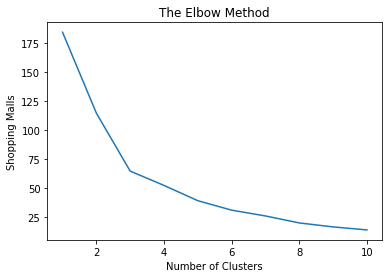

In [11]:
plt.plot(range(1,11),Shopping_malls)
plt.title("The Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Shopping Malls")
plt.show()

In [12]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [13]:
kmeans.labels_

array([2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 2, 2, 2, 1,
       1, 2, 1, 2])

In [14]:
udf.head()

localities  No of shopping malls  Population  \
0      Alandi Road                   8.0     28576.0   
1  Ambegaon Budruk                   2.0     23597.0   
2       Anandnagar                   2.0     10113.0   
3            Aundh                   6.0     17766.0   
4       Aundh Road                   6.0     15205.0   

   No of shopping malls_zscore  Population_zscore  
0                     2.236840           0.264729  
1                    -0.142227          -0.009255  
2                    -0.142227          -0.751250  
3                     1.443818          -0.330122  
4                     1.443818          -0.471048

## Examining CLusters 

In [15]:
k_merge=udf.copy()

In [16]:
k_merge["clustlabel"]=kmeans.labels_

In [17]:
k_merge.head()

localities  No of shopping malls  Population  \
0      Alandi Road                   8.0     28576.0   
1  Ambegaon Budruk                   2.0     23597.0   
2       Anandnagar                   2.0     10113.0   
3            Aundh                   6.0     17766.0   
4       Aundh Road                   6.0     15205.0   

   No of shopping malls_zscore  Population_zscore  clustlabel  
0                     2.236840           0.264729           2  
1                    -0.142227          -0.009255           1  
2                    -0.142227          -0.751250           1  
3                     1.443818          -0.330122           2  
4                     1.443818          -0.471048           2

In [18]:
k_merge.loc[k_merge['clustlabel'] == 0]

localities  No of shopping malls  Population  \
14            Camp                   8.0     79454.0   
15   Chandan Nagar                   0.0     66867.0   
18       Dehu Road                   0.0     48961.0   
40         Kharadi                   1.0     70000.0   
42  Kondhwa Budruk                   2.0     45476.0   
47     Lulla Nagar                   1.0     49363.0   
69   Sadashiv Peth                   4.0    100000.0   
78   Sinhagad Road                   5.0     60000.0   
81      Tilak Road                   1.0     99000.0   

    No of shopping malls_zscore  Population_zscore  clustlabel  
14                     2.236840           3.064435           0  
15                    -0.935249           2.371799           0  
18                    -0.935249           1.386471           0  
40                    -0.538738           2.544202           0  
42                    -0.142227           1.194699           0  
47                    -0.538738           1.408592           0  
69                     0.650796           4.195036           0  
78                     1.047307           1.993923           0  
81                    -0.538738           4.140009           0

In [19]:
k_merge.loc[k_merge['clustlabel'] == 1]

localities  No of shopping malls  Population  \
1              Ambegaon Budruk                   2.0     23597.0   
2                   Anandnagar                   2.0     10113.0   
5                 Balaji Nagar                   1.0     19916.0   
6                        Baner                   1.0     31972.0   
7                   Baner road                   0.0     24574.0   
8              Bhandarkar Road                   2.0     16120.0   
9                 Bhavani Peth                   1.0     17454.0   
10                   Bibvewadi                   3.0     14397.0   
11                      Bopodi                   1.0     15834.0   
12                Budhwar Peth                   4.0      8000.0   
13            Bund Garden Road                   1.0     14096.0   
16                      Dapodi                   1.0      4546.0   
17             Deccan Gymkhana                   2.0      6000.0   
19                  Dhankawadi                   1.0     25148.0   
20               Dhayari Phata                   1.0     21861.0   
21            Dhole Patil Road                   0.0     30023.0   
22                Fatima Nagar                   3.0      6500.0   
23      Fergusson College Road                   0.0     16120.0   
24                 Ganesh Peth                   2.0     14871.0   
25                 Ganeshkhind                   1.0     20138.0   
26               Ghorpade Peth                   0.0     12547.0   
27                    Ghorpadi                   1.0     25014.0   
28               Gokhale Nagar                   3.0     14614.0   
29                    Gultekdi                   3.0     16457.0   
30                Guruwar peth                   1.0      9500.0   
32  Hadapsar Industrial Estate                   1.0     29733.0   
33                Hingne Khurd                   0.0     21971.0   
34        Jangali Maharaj Road                   1.0     15228.0   
35               Kalyani Nagar                   3.0     25272.0   
36                 Karve Nagar                   3.0     29109.0   
..                         ...                   ...         ...   
49              Mangalwar peth                   0.0      8000.0   
50                  Manik Bagh                   0.0     20666.0   
51                 Market yard                   3.0     18923.0   
53                Mukund Nagar                   2.0     35527.0   
56                   Nana Peth                   2.0      8000.0   
57                Narayan Peth                   1.0     41572.0   
58                 Narayangaon                   1.0     20456.0   
59                   Navi Peth                   0.0      8000.0   
60                   Padmavati                   0.0     20700.0   
61             Parvati Darshan                   3.0     20279.0   
62                      Pashan                   2.0     24574.0   
63                   Paud Road                   2.0     18064.0   
64                    Pirangut                   0.0     14174.0   
65                Prabhat Road                   0.0     15228.0   
66        Pune Railway Station                   0.0     10000.0   
67                  Rasta Peth                   1.0     10752.0   
68                Raviwar Peth                   4.0     15953.0   
70               Sahakar Nagar                   0.0     20316.0   
71               Salunke Vihar                   0.0     24791.0   
72                 Sasson Road                   1.0     14192.0   
74         Senapati Bapat Road                   2.0     20138.0   
75               Shaniwar Peth                   4.0     13824.0   
77              Shukrawar Peth                   1.0     10000.0   
79                 Somwar Peth                   1.0     12273.0   
80                    Swargate                   1.0     31390.0   
82               Uruli Devachi                   3.0      9403.0   
83              Vadgaon Budruk                   1.0     25876.0   
87      

In [20]:
k_merge.loc[k_merge['clustlabel'] == 2]

localities  No of shopping malls  Population  \
0     Alandi Road                   8.0     28576.0   
3           Aundh                   6.0     17766.0   
4      Aundh Road                   6.0     15205.0   
31       Hadapsar                   8.0     40932.0   
52   Model colony                   7.0     14892.0   
54       Mundhawa                   6.0     19153.0   
55     Nagar Road                   6.0     26134.0   
73    Satara Road                   6.0      9935.0   
76  Shivaji Nagar                  12.0     13877.0   
84  Wadgaon Sheri                   6.0     39000.0   
85    Viman Nagar                   5.0     41000.0   
86  Vishrant Wadi                   5.0     24678.0   
89       Wanowrie                   5.0     18500.0   
91       Yerawada                  12.0      7685.0   

    No of shopping malls_zscore  Population_zscore  clustlabel  
0                      2.236840           0.264729           2  
3                      1.443818          -0.330122           2  
4                      1.443818          -0.471048           2  
31                     2.236840           0.944653           2  
52                     1.840329          -0.488272           2  
54                     1.443818          -0.253799           2  
55                     1.443818           0.130351           2  
73                     1.443818          -0.761045           2  
76                     3.822885          -0.544125           2  
84                     1.443818           0.838339           2  
85                     1.047307           0.948394           2  
86                     1.047307           0.050230           2  
89                     1.047307          -0.289732           2  
91                     3.822885          -0.884858           2

In [21]:
kmeans.cluster_centers_

array([[ 0.03400036,  2.47768509],
       [-0.37783496, -0.31091102],
       [ 1.8403292 , -0.06045038]])

In [22]:
y_km = kmeans.fit_predict(X)

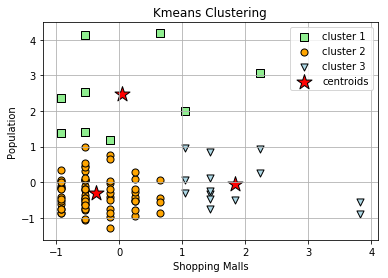

In [23]:
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.title("Kmeans Clustering")
plt.xlabel("Shopping Malls")
plt.ylabel("Population")
plt.grid()
plt.show()


## SILHOUETTE METHOD 

In [70]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [71]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer

In [72]:
def sil_score(X, from_k=2, to_k=6):
    '''
    calculate silhouette score for k clusters
    '''
    sils=[]
    for k in range(from_k, to_k + 1):
        m = KMeans(n_clusters=k)
        m.fit(X)
        # The silhouette_score gives the average value for all the samples
        silhouette_avg = silhouette_score(X, m.labels_).round(4)
        sils.append([silhouette_avg, k])
        
#         Compute the silhouette scores for each sample
#         sample_silhouette_values = silhouette_samples(X, m.labels_)
#         print(sample_silhouette_values)
#     return max(sils)[1]
    return sils

In [73]:
ss=sil_score(X, 2, 5)
print(f'scores = {ss}')
print(f'optimal number of clusters = {max(ss)[1]}')

scores = [[0.7811, 2], [0.62, 3], [0.6116, 4], [0.4775, 5]]
optimal number of clusters = 2


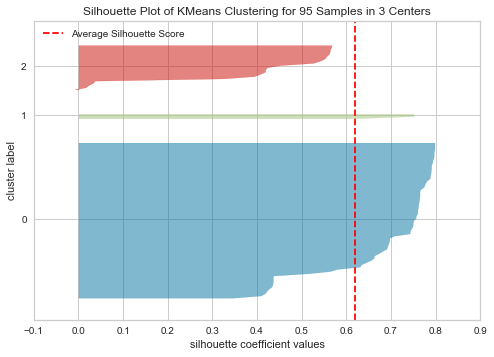

In [74]:
# Instantiate the clustering model and visualizer
model = KMeans(n_clusters=3,random_state=0)
visualizer = SilhouetteVisualizer(model,colors='yellowbrick')

visualizer.fit(X) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [75]:
def silhouette_plot(X, from_k, to_k):
    sil_scores=[]
    for k in range(from_k, to_k + 1):
        # Instantiate the clustering model and visualizer
        m = KMeans(n_clusters=k)
        visualizer = SilhouetteVisualizer(m)
        visualizer.fit(X) # Fit the training data to the visualizer
        visualizer.poof() # Draw/show/poof the data
#         print(visualizer.silhouette_score_)
#         sil_scores.append([k, visualizer.silhouette_score_])
        sil_scores.append([visualizer.silhouette_score_, k])
    return sil_scores

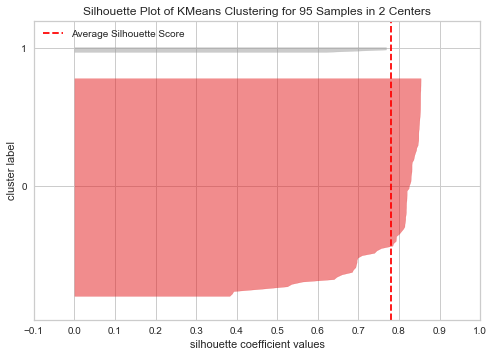

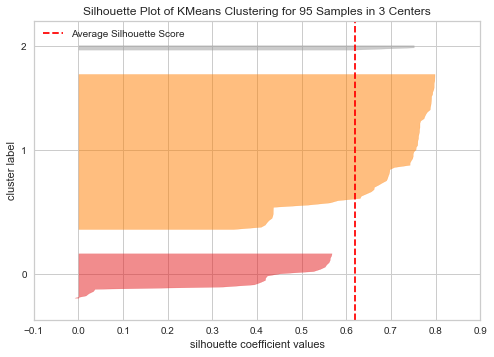

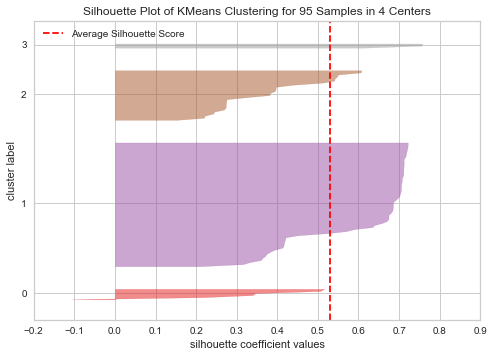

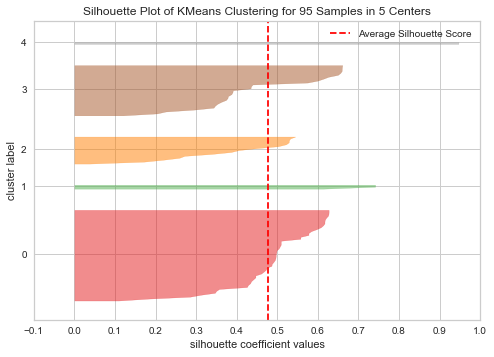

In [76]:
scores=silhouette_plot(X, 2, 5)